# SCANPY - PAGA

In [1]:
##########----- Reused code -----##########
# Last update: Sept 13, 2020
# By: Huitian Diao
# Python3.8 environment: sc_py3.8
###########################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
import csv
from astropy.io import ascii
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
import warnings
from pathlib import Path
from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

warnings.filterwarnings('ignore')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.4 numpy==1.19.2 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/codes_local","")

    wk_dir = base_dir + "/1_Scanpy"
    Path(wk_dir).mkdir(parents=True, exist_ok=True)
    sp_name = base_dir.split("/")[-1]
    outname_base = sp_name
else:
    print("Reload")

Reload


In [4]:
#--- Analysis name
analysis_name = ['0', "resampled"]
new_wk_dir = wk_dir + "/%s_Scanpy_out_%s"%(analysis_name[0], analysis_name[1])
Path(new_wk_dir).mkdir(parents=True, exist_ok=True)

print(sp_name, analysis_name)

0_Acute-Chronic ['0', 'resampled']


-----

## Configuration

In [4]:
min_gene_nu, min_cell_nu = 500, 3 # Minimum cell number for cell filtering

min_g_nav, max_g_nav = 1200, 2500
min_m_nav, max_m_nav = 0.02, 0.08
min_c_nav, max_c_nav = 2000, 10000

min_g_a, max_g_a = 1000, 8000
min_m_a, max_m_a = 0.01, 0.07
min_c_a, max_c_a = 2000, 65000

fa_n_denoise, fa_pc_denoise = 200, 50
fa_n, fa_pc = 250, 30

max_n_per_cond = 1250 # Maximun number of cells to use per condition

filter_celltypes = ["NWT"]

## Import data

In [5]:
os.chdir(wk_dir)

mtx_dir = base_dir + "/0_cellranger_outs_XL_folder/outs/filtered_feature_bc_matrix"  # the directory with the `.mtx` file

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
results_file = './write/%s_paga.h5ad'%outname_base  # the file that will store the analysis results
sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx(mtx_dir, var_names='gene_symbols', cache=True)
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it
adata.var_names_make_unique()

os.chdir(new_wk_dir)

adata

... reading from cache file cache/media-pipkin-ROCKET-PRO-CD8_DEV_SC-0_Acute-Chronic-0_cellranger_outs_XL_folder-outs-filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 18353 × 22630
    var: 'gene_ids', 'feature_types'

## 0. Pre-processing

### 0.1 Add in cell type data

In [6]:
cell_type_info = base_dir + "/0_cellranger_outs_XL_folder/Hashtag_count/0_Acute-Chronic_Cells_hashTags.csv"
with open(cell_type_info, 'r') as f:
  reader = csv.reader(f)
  cell_type_list = list(reader)
cell_type_list = [x[0] for x in cell_type_list]

adata.obs["cell_type"] = cell_type_list

# Filter out ambigous cells
adata = adata[adata.obs['cell_type'] != "Doublet", :]
adata = adata[adata.obs['cell_type'] != "Negative", :]

# Filter out cell types that we do not analyze this time
for i in filter_celltypes:
    adata = adata[adata.obs['cell_type'] != i, :]

### 0.2 Basic filtering & Mitochondrial filtering (Remove bad quality cells)

filtered out 589 cells that have less than 500 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 8117 genes that are detected in less than 3 cells


Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


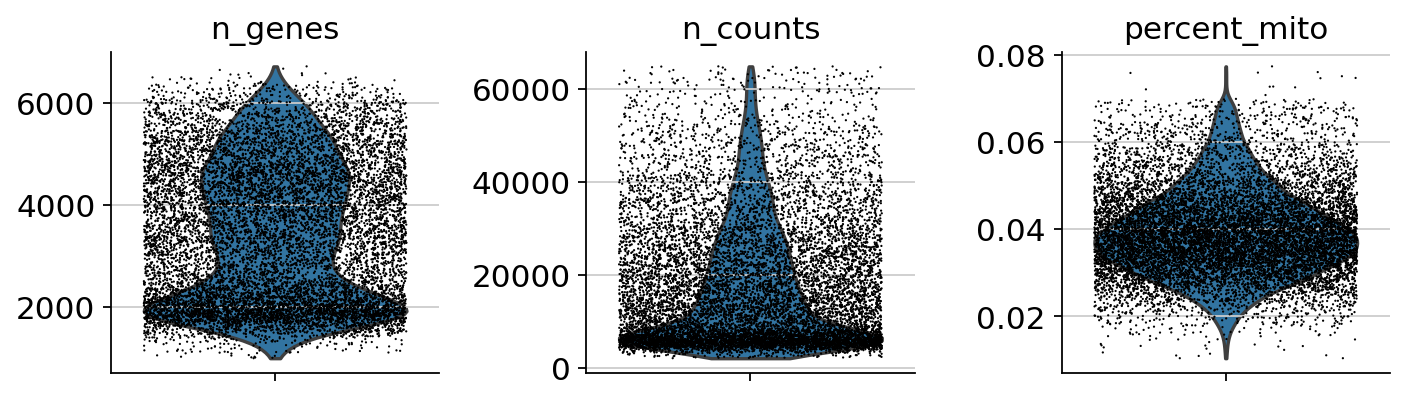

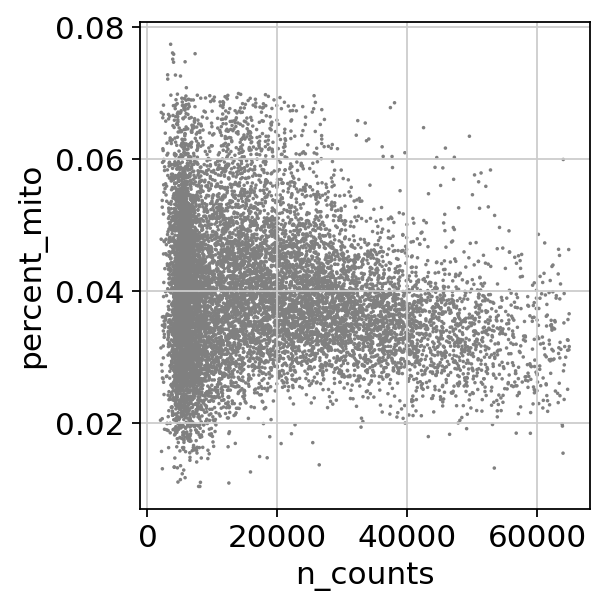

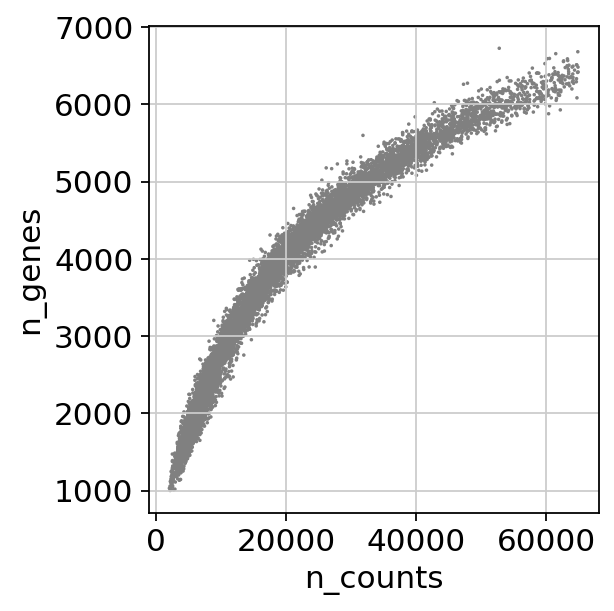

In [7]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=min_gene_nu)
sc.pp.filter_genes(adata, min_cells=min_cell_nu)

# Mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

###----- Naive cell filter
#sc.pl.violin(adata[adata.obs['cell_type']=="NP14B"], ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
#sc.pl.scatter(adata[adata.obs['cell_type']=="NP14B"], x='n_counts', y='percent_mito')
#sc.pl.scatter(adata[adata.obs['cell_type']=="NP14B"], x='n_counts', y='n_genes')
use_list = []
for i in range(len(adata.obs)):
    if adata.obs['cell_type'][i] != "NP14B":
        use_list.append(True)
    else:
        i_genes = ((adata.obs['n_genes'][i] >= min_g_nav) and (adata.obs['n_genes'][i] <= max_g_nav))
        i_mito = ((adata.obs['percent_mito'][i] >= min_m_nav) and (adata.obs['percent_mito'][i] <= max_m_nav))
        i_c = ((adata.obs['n_counts'][i] >= min_c_nav) and (adata.obs['n_counts'][i] <= max_c_nav))
        if all([i_genes, i_mito, i_c]):
            use_list.append(True)
        else:
            use_list.append(False)
adata = adata[use_list, :]

###----- Activated cell filter
#sc.pl.violin(adata[adata.obs['cell_type']!="NP14B"], ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
#sc.pl.scatter(adata[adata.obs['cell_type']!="NP14B"], x='n_counts', y='percent_mito')
#sc.pl.scatter(adata[adata.obs['cell_type']!="NP14B"], x='n_counts', y='n_genes')
use_list = []
for i in range(len(adata.obs)):
    if adata.obs['cell_type'][i] == "NP14B":
        use_list.append(True)
    else:
        i_genes = ((adata.obs['n_genes'][i] >= min_g_a) and (adata.obs['n_genes'][i] <= max_g_a))
        i_mito = ((adata.obs['percent_mito'][i] >= min_m_a) and (adata.obs['percent_mito'][i] <= max_m_a))
        i_c = ((adata.obs['n_counts'][i] >= min_c_a) and (adata.obs['n_counts'][i] <= max_c_a))
        if all([i_genes, i_mito, i_c]):
            use_list.append(True)
        else:
            use_list.append(False)
adata = adata[use_list, :]

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

### 0.3 Normalization

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


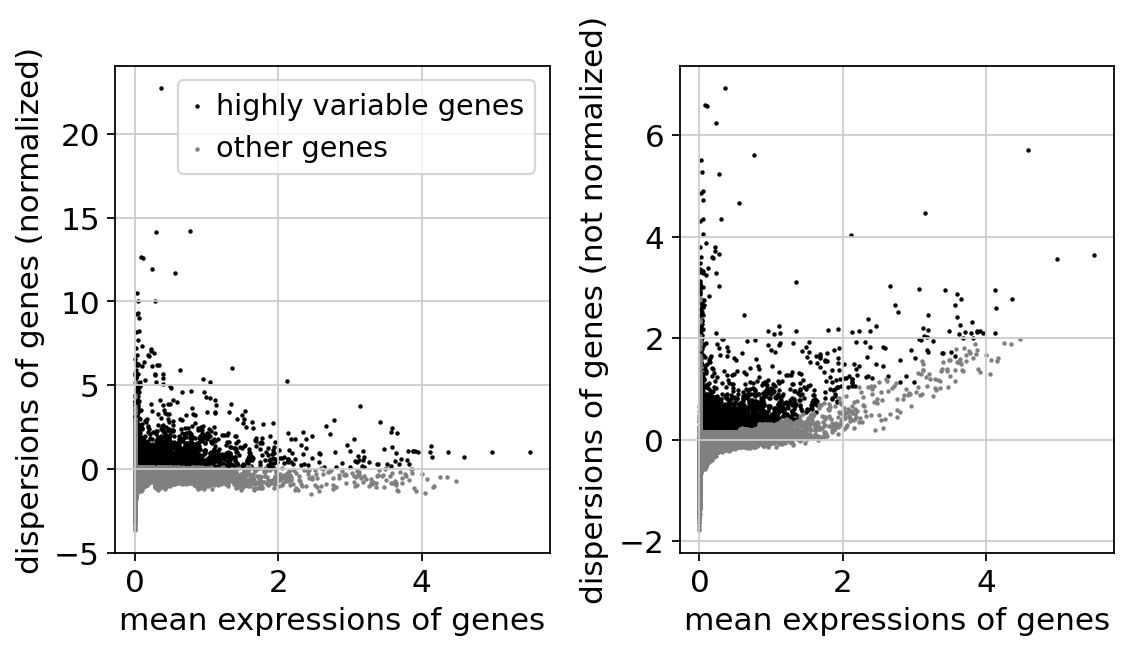

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:58)


In [8]:
# Total-count normalize the data matrix to 10,000 reads per cell, so the counts become comparable among cells
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.002, max_mean=10, min_disp=0.1)
sc.pl.highly_variable_genes(adata)

adata.raw = adata
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata, max_value=10) 

# Write for Harmony
write_flag = False
write_dir = new_wk_dir + '/counts_XL_folder'
Path(write_dir).mkdir(parents=True, exist_ok=True)
if write_flag:
    raw_array = adata.X
    pd_raw_df = pd.DataFrame(raw_array)
    pd_raw_df.columns = list(adata.var.index.values)
    col_names = list(pd_raw_df.columns.values)
    pd_raw_df.index = list(adata.obs.index.values)
    pd_raw_df.to_csv("%s/all_norm_counts_named_log_scaled.csv"%write_dir)     

### 0.4 Outlier detection

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:35)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:49)


... storing 'y_pred' as categorical


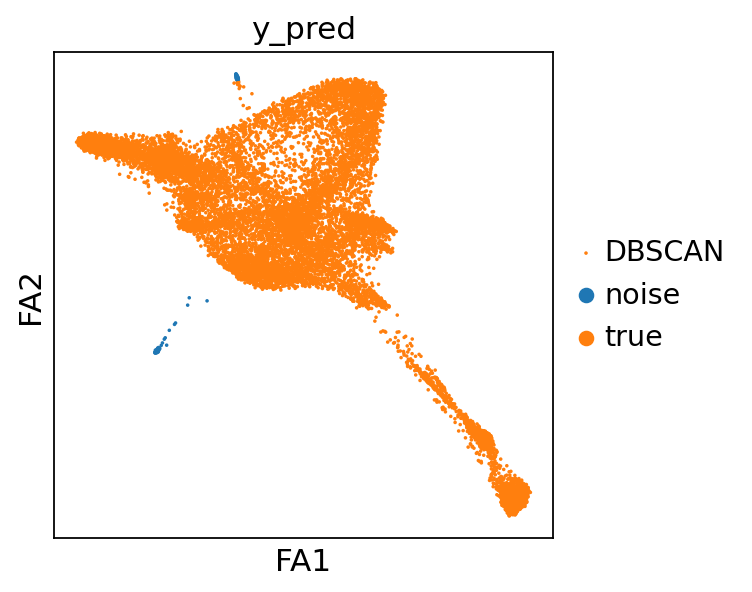

Counter({'true': 11639, 'noise': 85})


In [9]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=fa_n_denoise, n_pcs=fa_pc_denoise)
sc.tl.draw_graph(adata)

adata_fa = pd.DataFrame(adata.obsm["X_draw_graph_fa"])
clustering = DBSCAN(eps=12000, min_samples=100).fit(adata.obsm["X_draw_graph_fa"])
y_pred = ["noise" if x == -1 else "true" for x in list(clustering.labels_)]
Counter(y_pred)
adata.obs["y_pred"] = y_pred
sc.pl.draw_graph(adata, color='y_pred', label="DBSCAN")

print(Counter(list(y_pred)))
adata = adata[adata.obs["y_pred"] == "true"]

In [9]:
del adata.obsm
del adata.uns
del adata.varm
del adata.obsp
adata.write("%s_outlier_removed.h5ad"%outname_base)

### 0.5 Cell number capping

In [10]:
if True:
    # Use Specified number of cells per condition
    cell_type_use = []
    cell_type_set = list(set(list(adata.obs['cell_type'])))
    print(Counter(list(adata.obs['cell_type'])))
    cell_type_dict = {key:0 for key in cell_type_set}
    for i in list(adata.obs['cell_type']):
        cell_type_dict[i] += 1
        if cell_type_dict[i] <= max_n_per_cond:
            cell_type_use.append("Yes")
        else:
            cell_type_use.append("No")

    adata.obs['use'] = cell_type_use
    adata = adata[adata.obs['use'] == "Yes", :]
    print(Counter(list(adata.obs['cell_type'])))

adata.write("%s_resampled.h5ad"%outname_base)

Trying to set attribute `.obs` of view, copying.
... storing 'use' as categorical


Counter({'A5T': 2733, 'A5P': 2464, 'C5P': 2138, 'A8T': 1486, 'A8P': 1132, 'NP14B': 908, 'C8P': 763})
Counter({'C5P': 1250, 'A8T': 1250, 'A5P': 1250, 'A5T': 1250, 'A8P': 1132, 'NP14B': 908, 'C8P': 763})


-----
## Resampled Reload point

In [11]:
adata = sc.read_h5ad("%s_resampled.h5ad"%outname_base)

## 1. Clustering and PAGA

In [12]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=fa_n, n_pcs=fa_pc)
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:10)


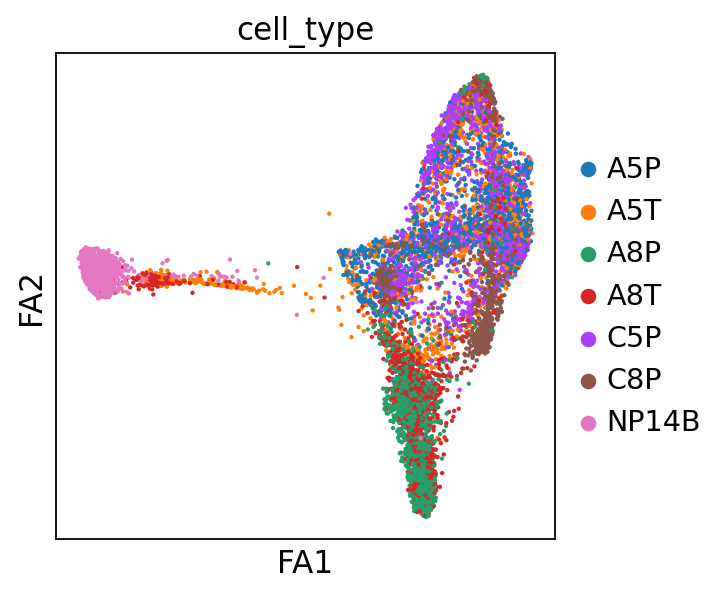

In [13]:
sc.pl.draw_graph(adata, color='cell_type')

In [14]:
adata.write("%s_resampled_nn.h5ad"%outname_base)

In [62]:
os.chdir(new_wk_dir)
adata = sc.read_h5ad("%s_resampled_nn.h5ad"%outname_base)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:05)
----------
Counter({'0': 1193, '1': 960, '2': 956, '3': 902, '4': 817, '5': 806, '6': 577, '7': 505, '8': 443, '9': 334, '10': 310})
----------
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


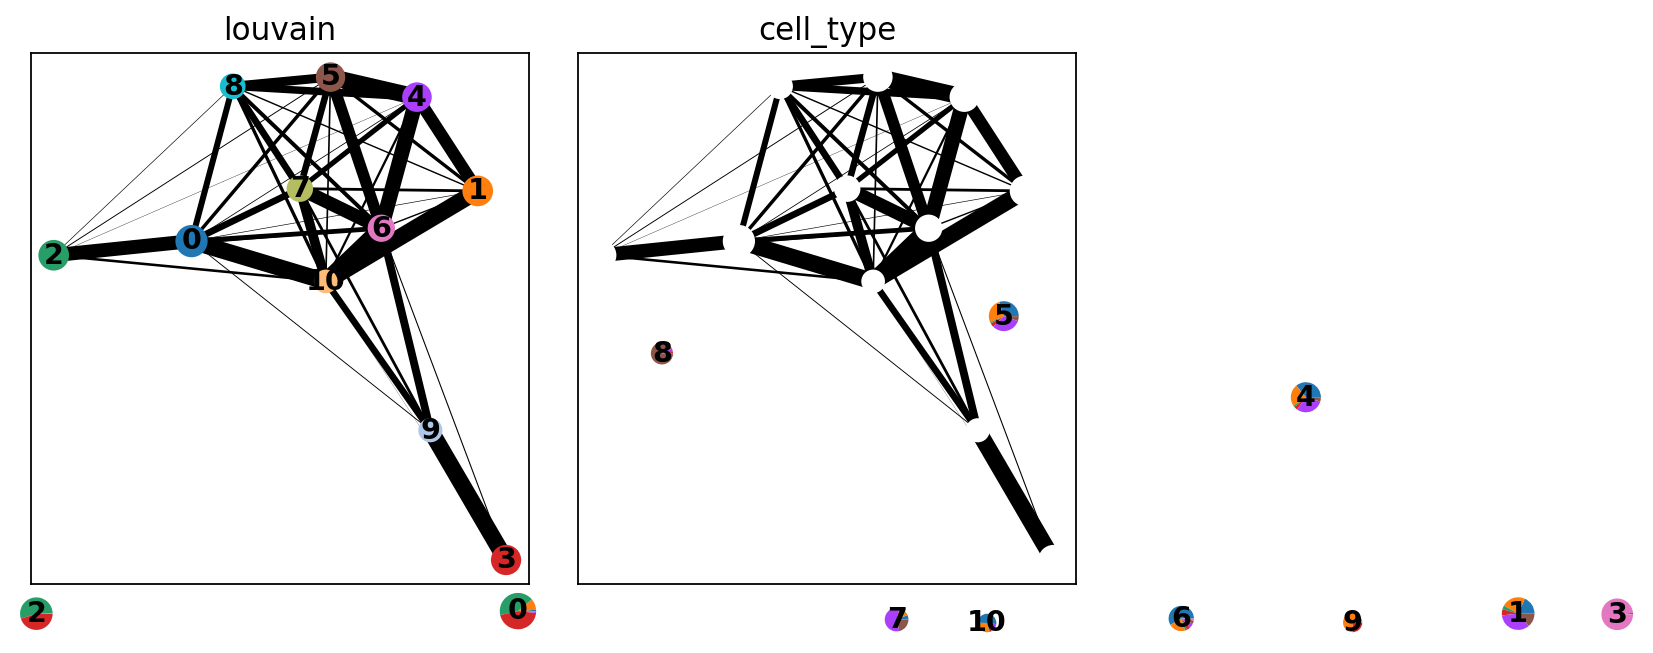

In [63]:
sc.tl.louvain(adata, resolution=1.8)
print("----------")
print(Counter(list(adata.obs['louvain'])))
print("----------")
sc.tl.paga(adata, groups='louvain')
sc.pl.paga(adata, color=['louvain', 'cell_type'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


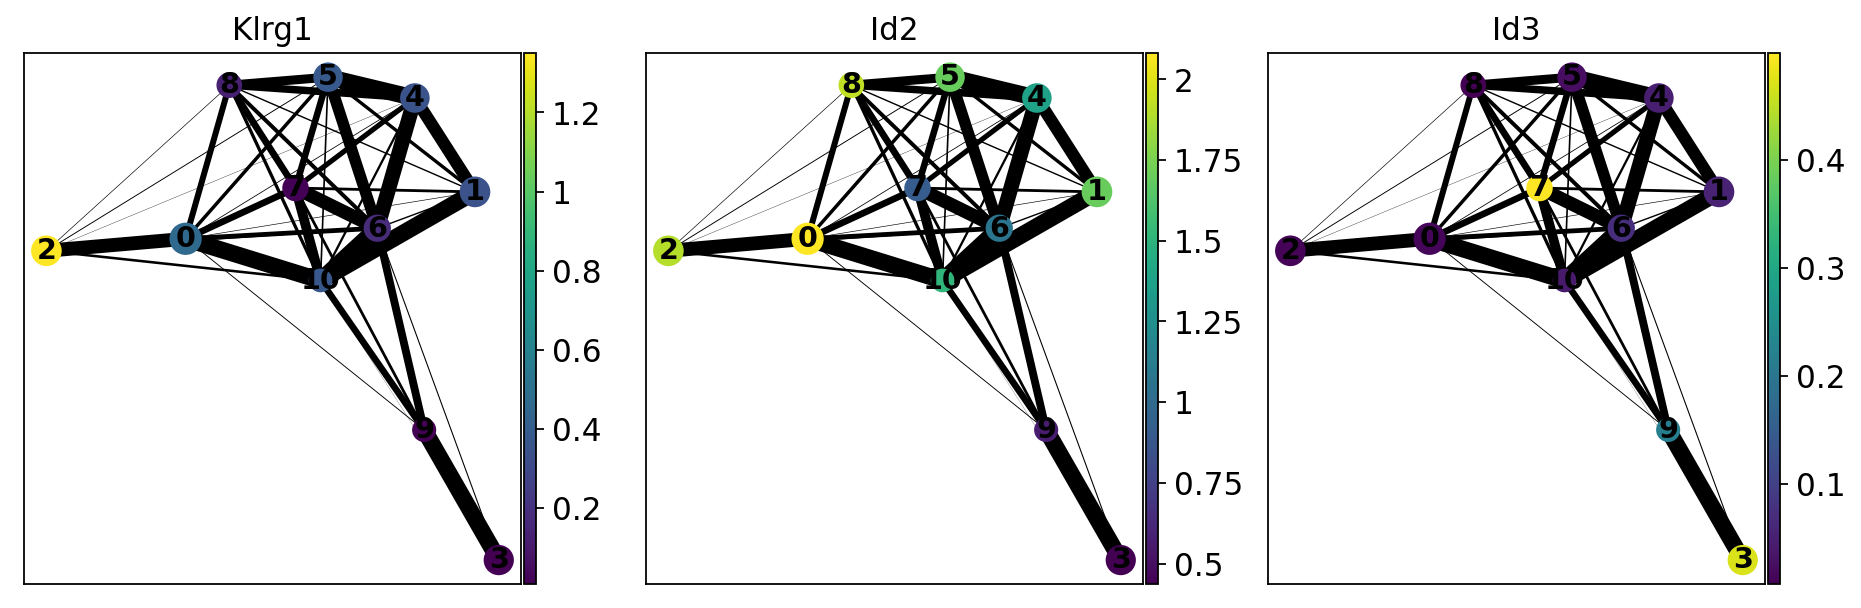

In [64]:
sc.pl.paga(adata,color=['Klrg1','Id2', 'Id3'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


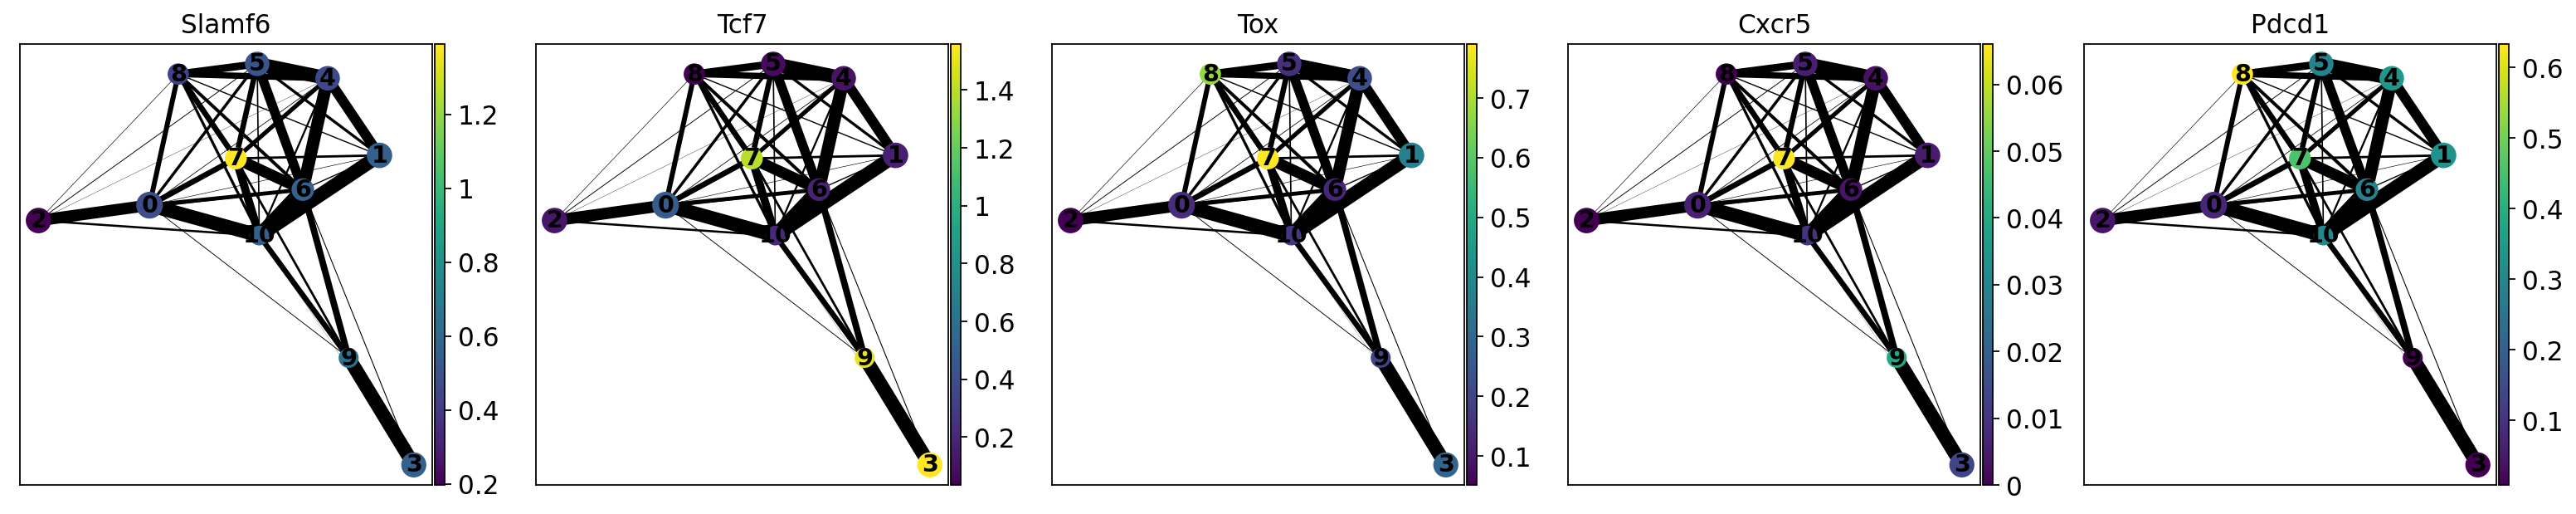

In [65]:
sc.pl.paga(adata, color=['Slamf6', 'Tcf7', 'Tox', 'Cxcr5', 'Pdcd1'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


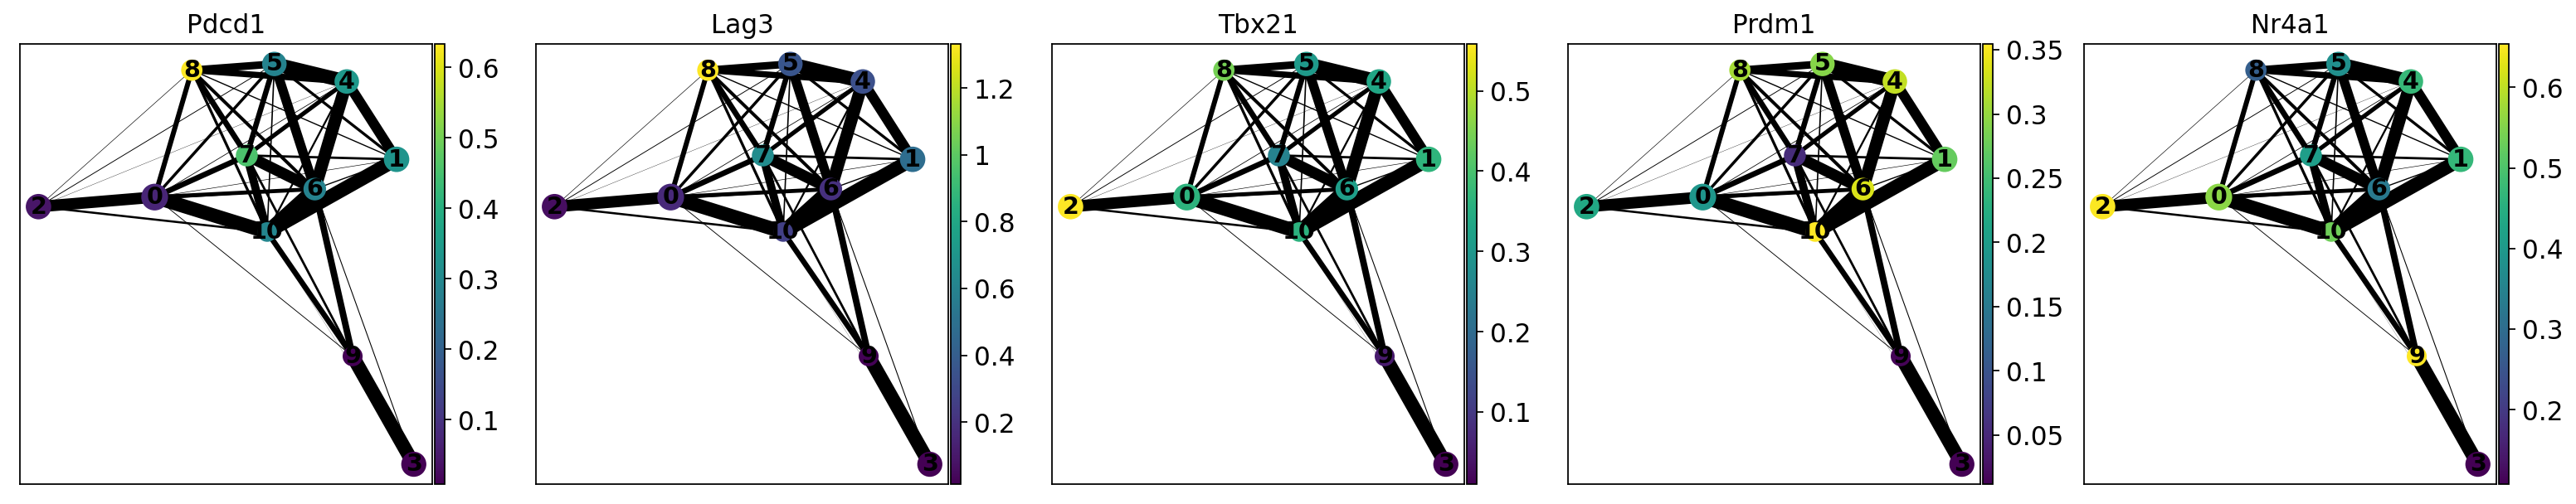

In [66]:
sc.pl.paga(adata, color=['Pdcd1',  'Lag3', 'Tbx21', 'Prdm1', 'Nr4a1'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


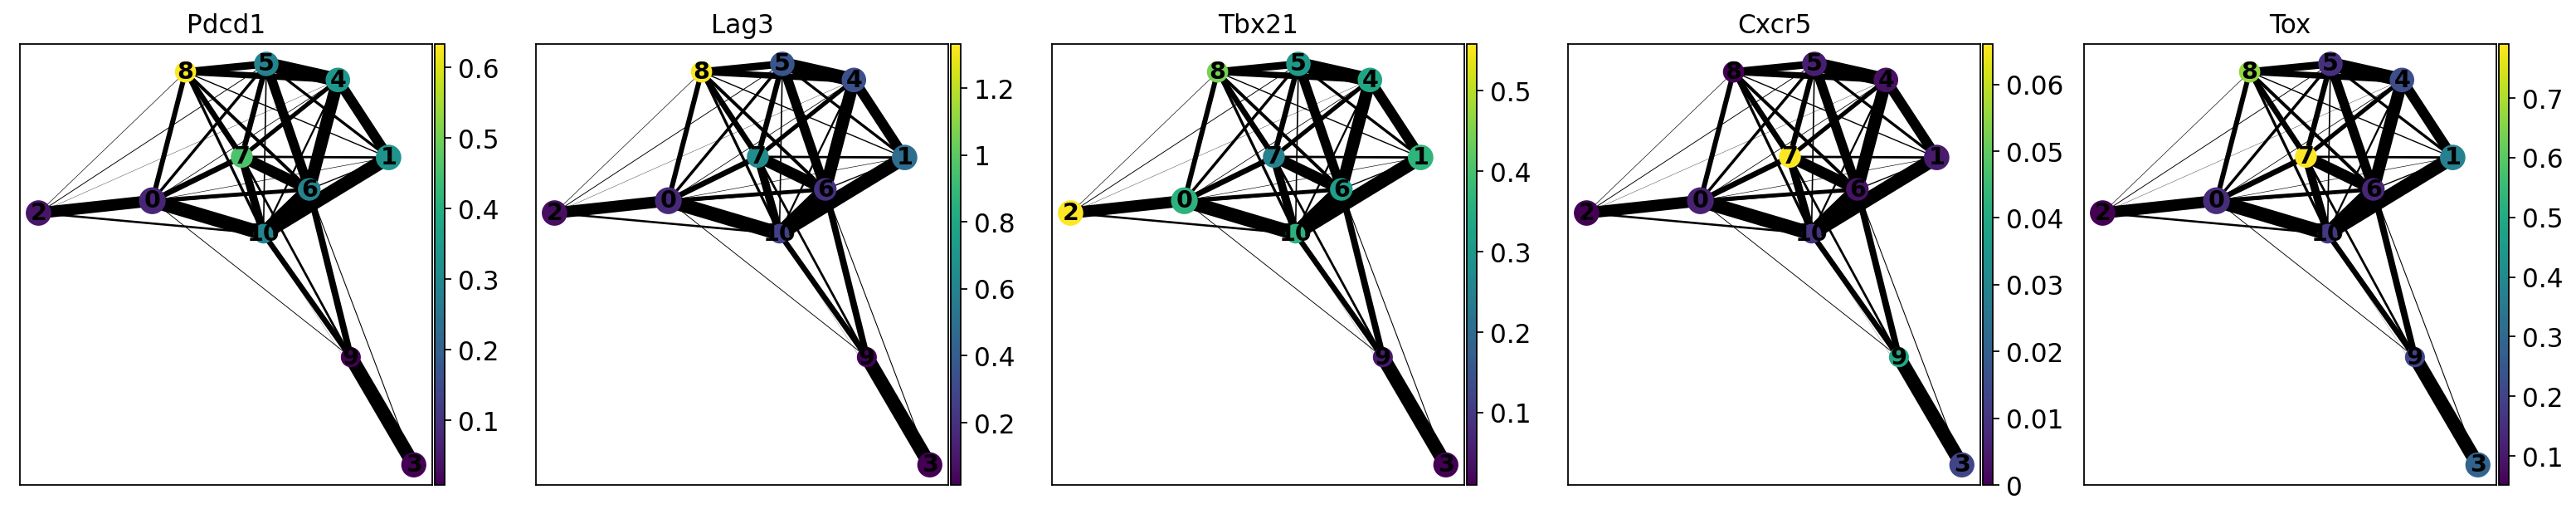

In [67]:
sc.pl.paga(adata, color=['Pdcd1',  'Lag3', 'Tbx21', 'Cxcr5', 'Tox'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


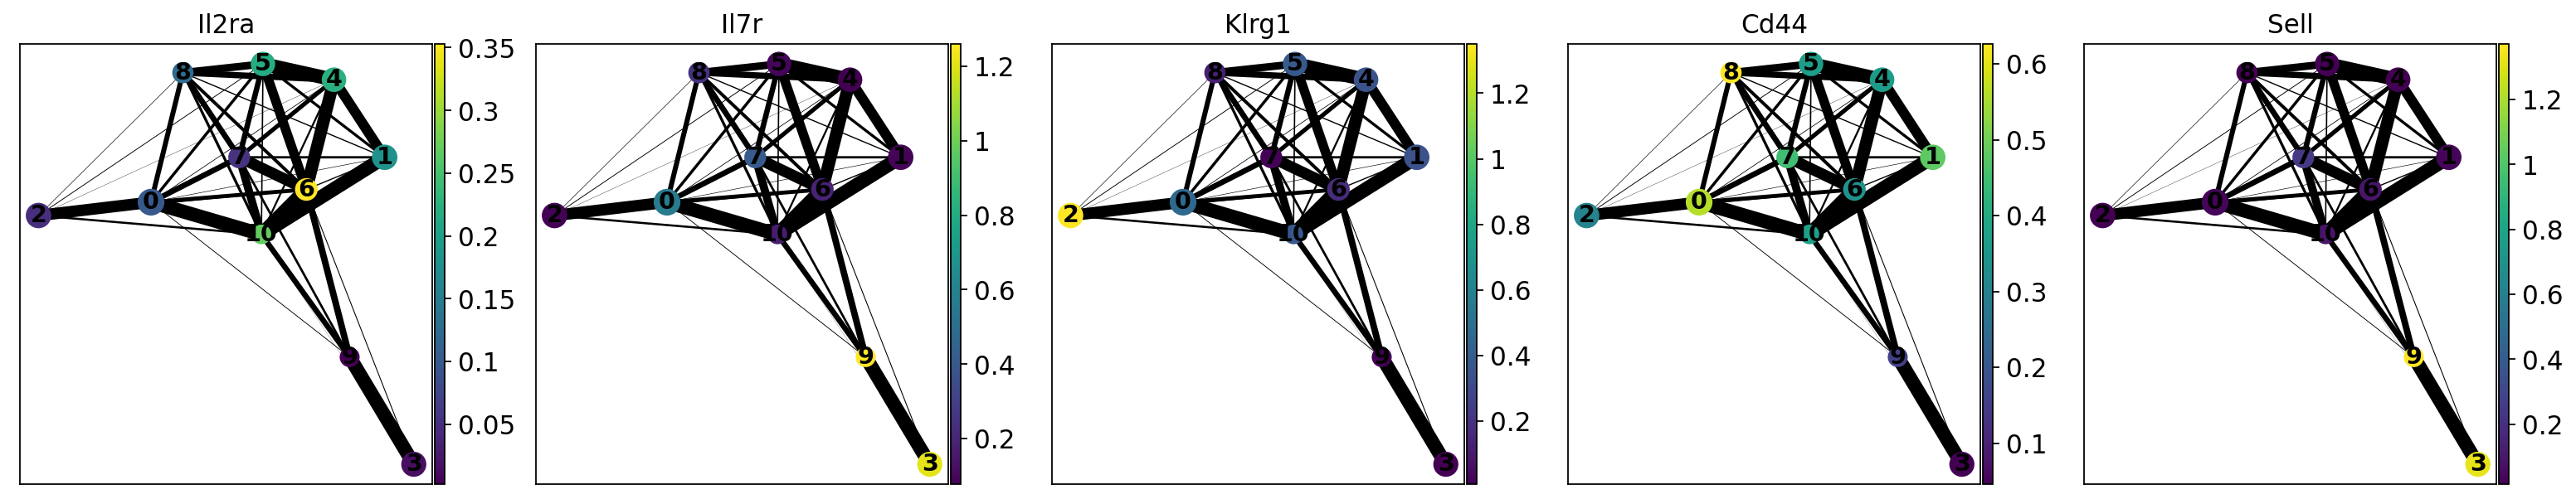

In [68]:
sc.pl.paga(adata, color=['Il2ra', 'Il7r','Klrg1','Cd44','Sell'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


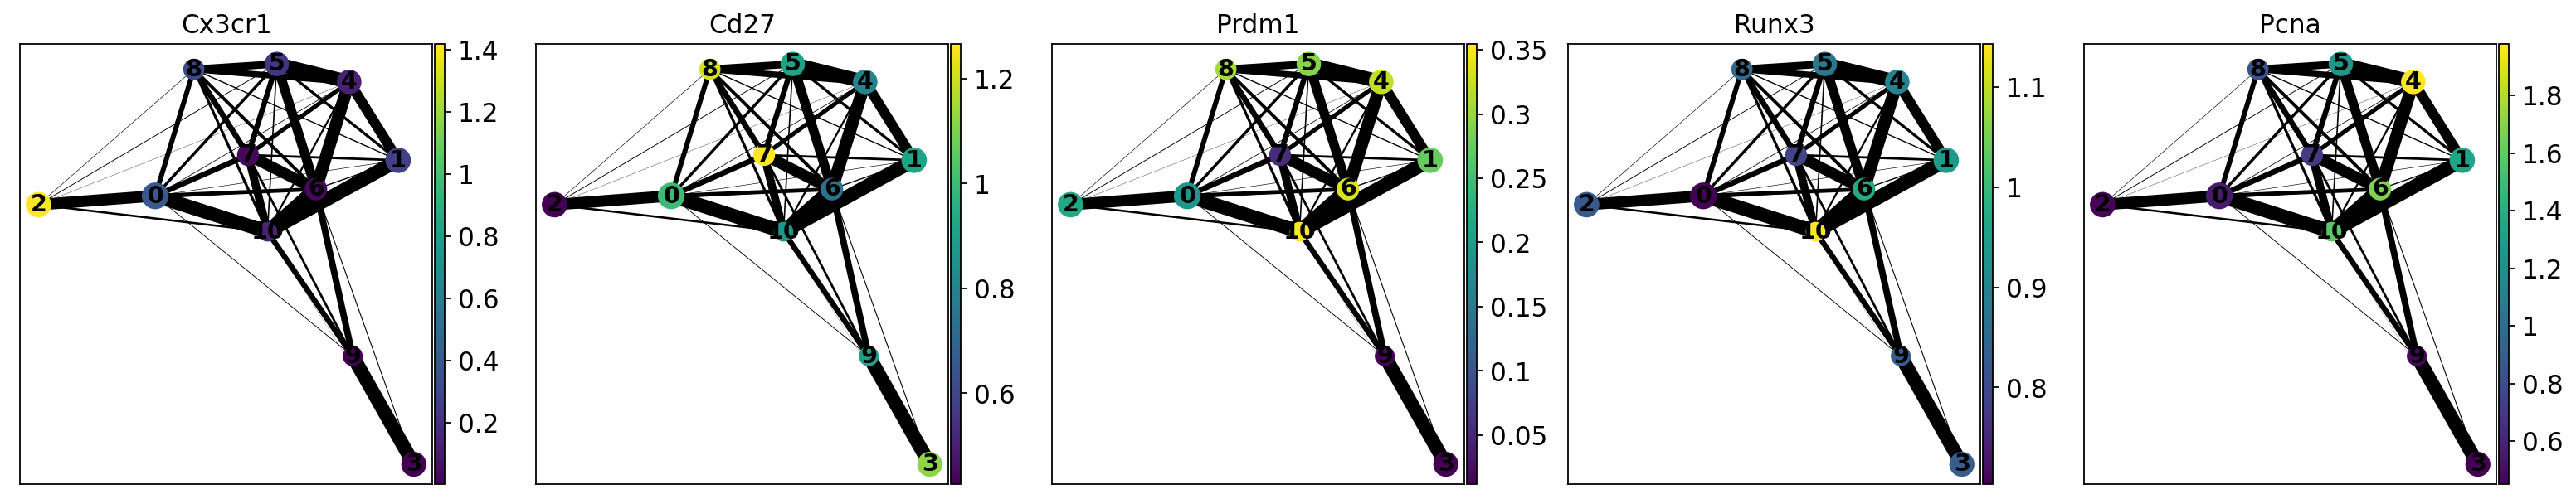

In [69]:
sc.pl.paga(adata, color=['Cx3cr1','Cd27', 'Prdm1', 'Runx3','Pcna'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


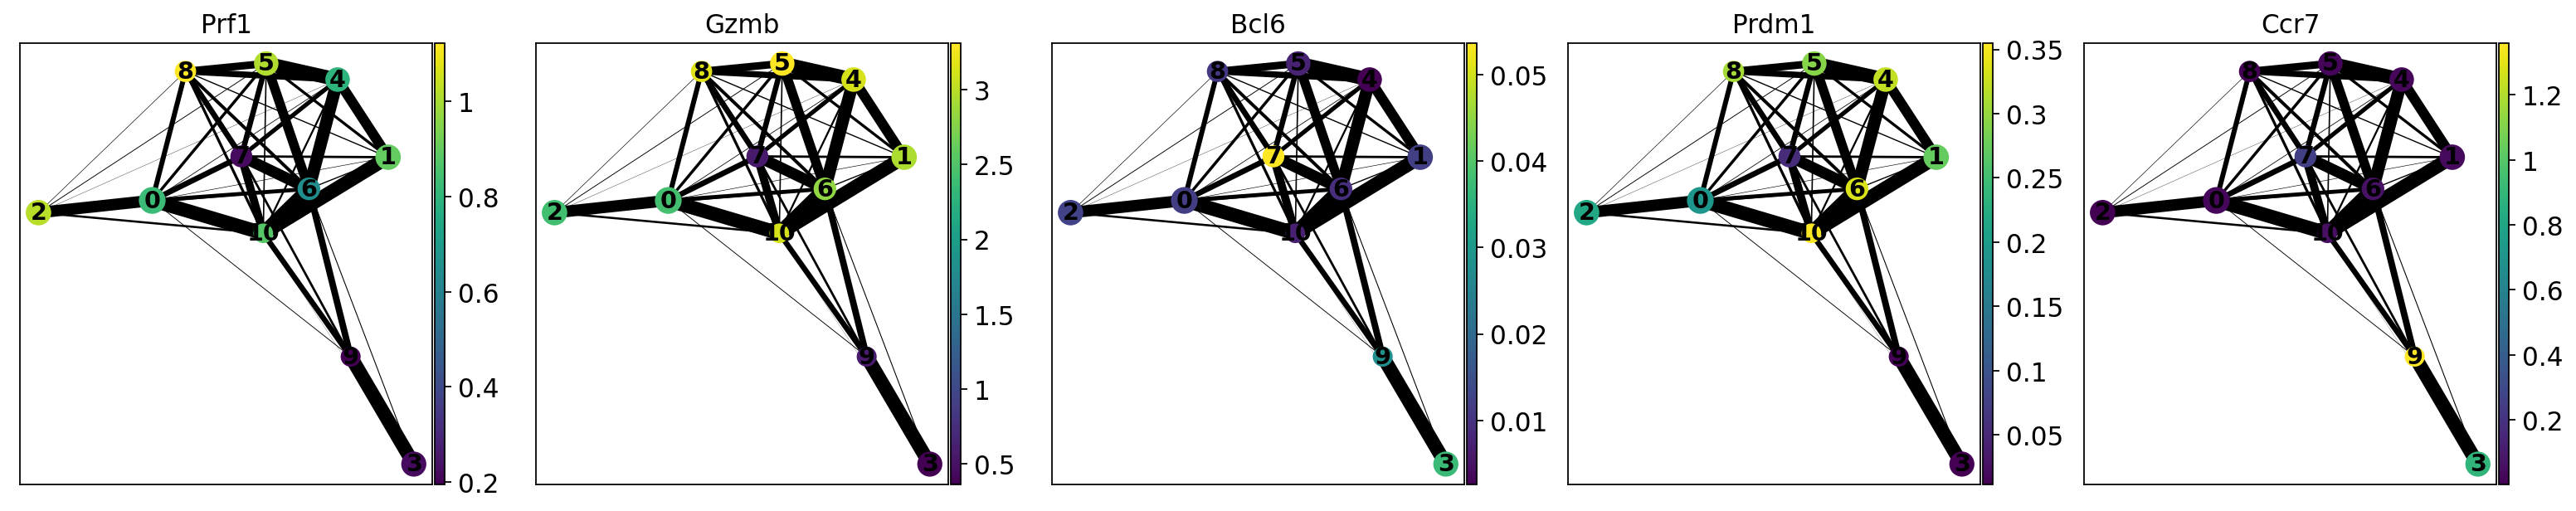

In [70]:
sc.pl.paga(adata, color=['Prf1', 'Gzmb', 'Bcl6','Prdm1','Ccr7'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


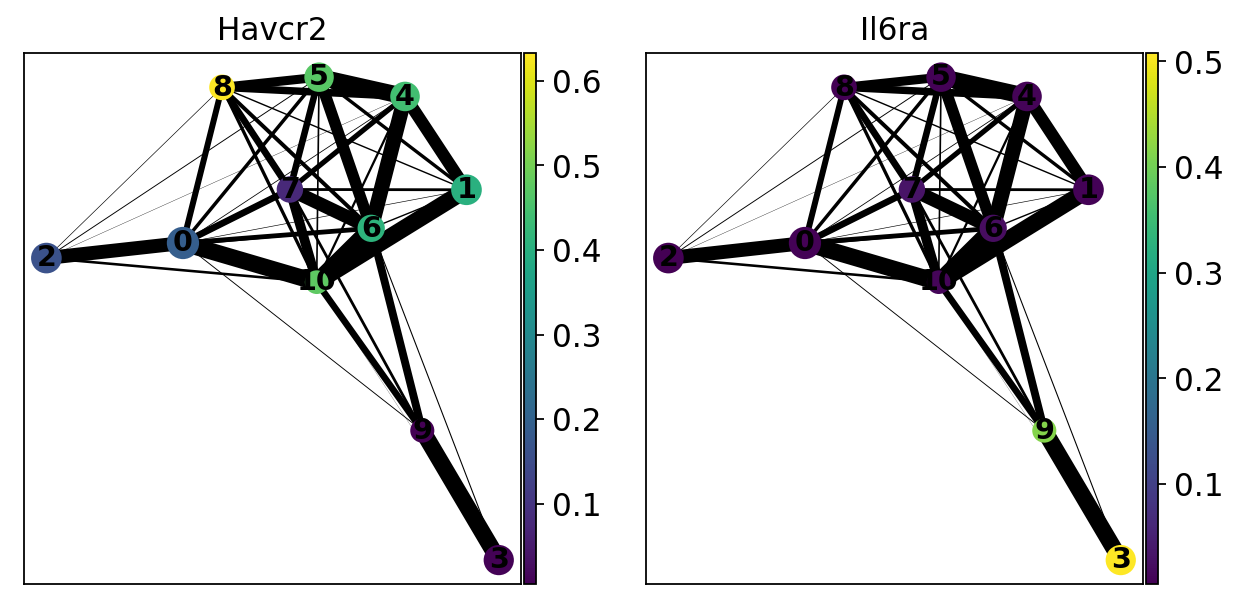

In [71]:
sc.pl.paga(adata, color=['Havcr2', 'Il6ra'])

### 1.1 Recomputing the embedding using PAGA-initialization

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:12)


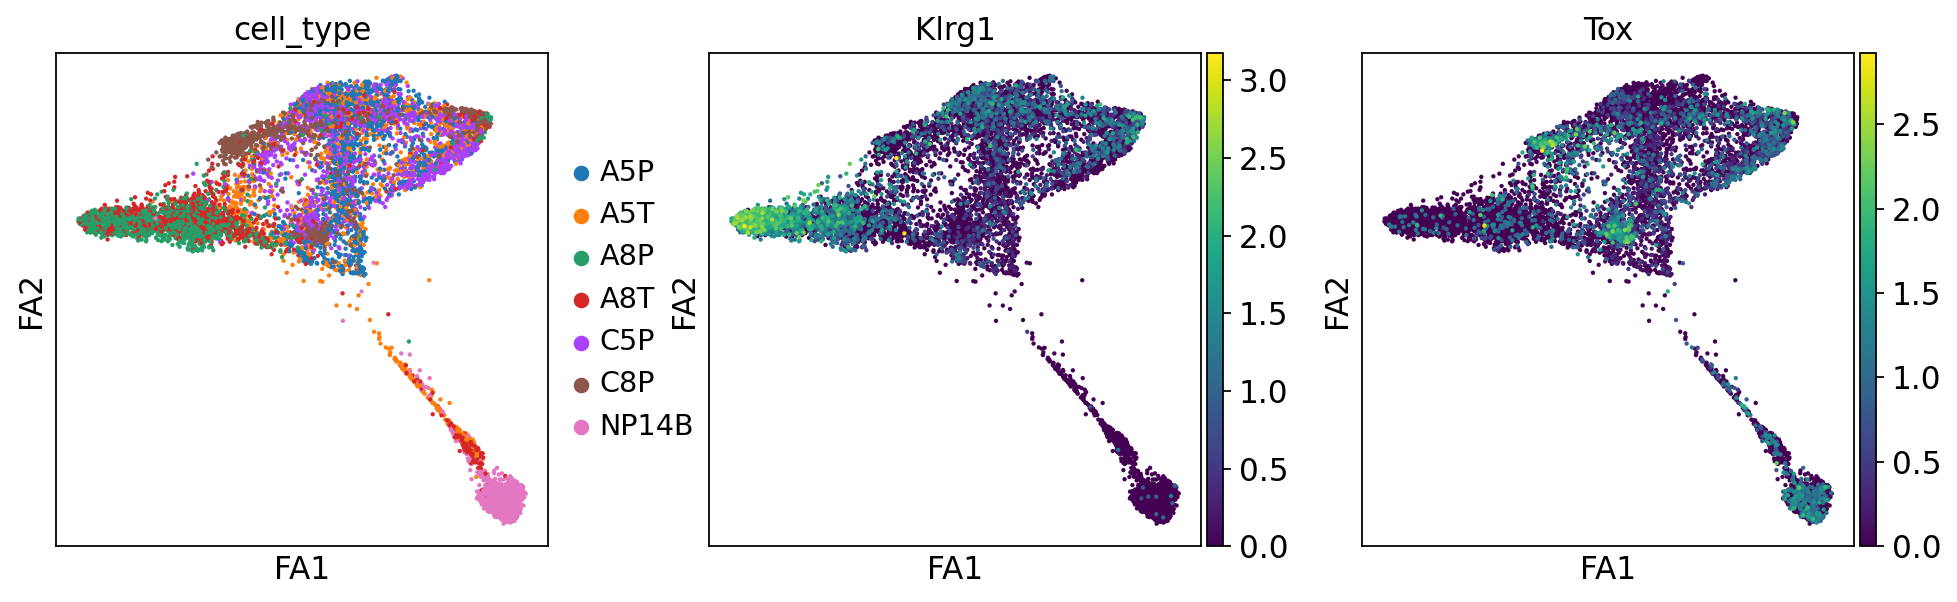

In [72]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=['cell_type', 'Klrg1', 'Tox'])

In [73]:
adata.write("%s_paga_prePseudotime.h5ad"%outname_base)

In [128]:
adata

AnnData object with n_obs × n_vars = 7803 × 4645
    obs: 'cell_type', 'n_genes', 'percent_mito', 'n_counts', 'y_pred', 'use', 'louvain', 'day'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'draw_graph', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'diffmap_evals', 'iroot'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### 1.2 Reconstructing gene changes along PAGA paths for a given set of genes

In [4]:
os.chdir(new_wk_dir)
adata = sc.read_h5ad("%s_paga_prePseudotime.h5ad"%outname_base)

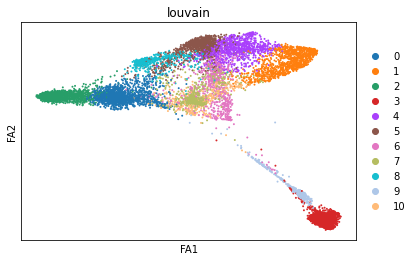

In [5]:
sc.pl.draw_graph(adata, color=['louvain'], save="louvain.png")

... storing 'day' as categorical


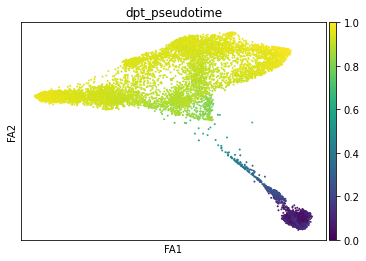

In [9]:
adata.obs['day'] = [x[1] for x in adata.obs['cell_type']]
adata.obs['day'] = [x.replace('P', '0') for x in adata.obs['day']]

adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_type'] == 'NP14B')[0]

p14nav_array = np.flatnonzero(adata.obs['cell_type']  == 'NP14B')
louvain0_array = np.flatnonzero(adata.obs['louvain']  == '3')
p14nav_louvain0_array = np.intersect1d(p14nav_array, louvain0_array)
adata.uns['iroot'] = p14nav_louvain0_array[0]


sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['dpt_pseudotime'])

### Save object

In [64]:
os.chdir(new_wk_dir)
adata.write("%s_paga.h5ad"%outname_base)

###----- Save whole object
adata.write_csvs("%s_paga"%outname_base)

In [67]:
###----- Write Paga Connectivity
paga_connect = pd.DataFrame(adata.uns['paga']['connectivities'].A)
paga_connect_tree = pd.DataFrame(adata.uns['paga']['connectivities_tree'].A)
paga_pos = pd.DataFrame(adata.uns['paga']['pos'])

paga_connect.to_csv("%s_paga/paga_connect.csv"%outname_base, sep=',')
paga_connect_tree.to_csv("%s_paga/paga_connect_tree.csv"%outname_base, sep=',')
paga_pos.to_csv("%s_paga/paga_pos.csv"%outname_base, sep=',')

-----

## 2. Summary & Average expression

In [5]:
os.chdir(new_wk_dir)
adata = sc.read_h5ad("%s_paga.h5ad"%outname_base)

### 2.0 Summary

In [32]:
sum_dir = new_wk_dir + "/0_sum"
Path(sum_dir).mkdir(parents=True, exist_ok=True)
os.chdir(sum_dir)

In [33]:
###----- Calculate cell type distrubution
cell_type_uniq = list(set(list(adata.obs['cell_type'])))
louvain_uniq = list(set(list(adata.obs['louvain'])))
louvain_uniq_use = list( range(0,(max([int(i) for i in louvain_uniq]) + 1)))
louvain_type_count_tb = pd.DataFrame(data = {'louvain': louvain_uniq_use})
louvain_type_pctg_tb = pd.DataFrame(data = {'louvain': louvain_uniq_use})
for type_i in cell_type_uniq:
    #print(type_i)
    number_i = []
    pctg_i = []
    typ_i_louvain = list(adata.obs[adata.obs["cell_type"] == type_i]["louvain"])
    for i in louvain_uniq_use:
        #print(i)
        louvain_i_number = typ_i_louvain.count(str(i))
        louvain_i_pctg = float(louvain_i_number)*100/len(typ_i_louvain)
        number_i.append(louvain_i_number)
        pctg_i.append(louvain_i_pctg)
    louvain_type_count_tb[type_i] = number_i
    louvain_type_pctg_tb[type_i] = pctg_i
louvain_type_pctg_tb.to_csv("%s_Louvain--CellType_pctg.csv"%outname_base, index=False)
louvain_type_count_tb.to_csv("%s_Louvain--CellType_count.csv"%outname_base, index=False)

In [34]:
###----- Write Paga Connectivity
paga_connect = pd.DataFrame(adata.uns['paga']['connectivities'].A)
paga_connect_tree = pd.DataFrame(adata.uns['paga']['connectivities_tree'].A)
paga_pos = pd.DataFrame(adata.uns['paga']['pos'])

paga_connect.to_csv("%s_paga_connect.csv"%outname_base, sep=',')
paga_connect_tree.to_csv("%s_paga_connect_tree.csv"%outname_base, sep=',')
paga_pos.to_csv("%s_paga_pos.csv"%outname_base, sep=',')

In [35]:
###----- Obs average
adata.obs['counts_per_gene'] = adata.obs['n_counts'] / adata.obs['n_genes']
# Average by louvain
adata_obs_mean = adata.obs.groupby(['louvain']).mean()
adata_obs_mean = adata_obs_mean.sort_values(by="dpt_pseudotime")
adata_obs_mean.to_csv("%s_obs_louvainAvg.csv"%outname_base)
adata_obs_mean

n_genes  percent_mito      n_counts  dpt_pseudotime  \
louvain                                                            
3        1848.579823      0.047448   5689.143066        0.050234   
9        2011.673653      0.035837   7206.557129        0.270792   
6        5088.774697      0.035143  38538.804688        0.848685   
10       5546.503226      0.036929  44647.820312        0.880940   
7        3494.601980      0.047731  16385.744141        0.886436   
0        2371.534786      0.038221   7872.590820        0.915782   
5        3719.730769      0.038954  18219.667969        0.935234   
8        2842.609481      0.035651  10473.000000        0.937531   
4        3941.193390      0.042707  20430.349609        0.938588   
2        1902.425732      0.034789   5302.241699        0.949905   
1        4263.628125      0.038973  23228.144531        0.952164   

         counts_per_gene  
louvain                   
3               3.060307  
9               3.473849  
6               7.164772  
10              7.780914  
7               4.453455  
0               3.166986  
5               4.676352  
8               3.500343  
4               4.948931  
2               2.755101  
1               5.256776

In [36]:
# Average by cell type
adata_obs_mean = adata.obs.groupby(['cell_type']).mean()
adata_obs_mean = adata_obs_mean.sort_values(by="dpt_pseudotime")
adata_obs_mean.to_csv("%s_obs_ctAvg.csv"%outname_base)
adata_obs_mean

n_genes  percent_mito      n_counts  dpt_pseudotime  \
cell_type                                                            
NP14B      1850.168502      0.047442   5674.370117        0.058533   
A5T        3706.848000      0.036752  20816.617188        0.791699   
A8T        2202.864000      0.038889   7046.847168        0.876722   
A5P        4795.260000      0.038573  32174.609375        0.906883   
C5P        4051.462400      0.043488  21671.189453        0.923569   
A8P        2180.500883      0.035328   6696.652832        0.933955   
C8P        3124.882045      0.037685  12841.080078        0.934310   

           counts_per_gene  
cell_type                   
NP14B             3.054580  
A5T               5.059081  
A8T               3.075019  
A5P               6.395952  
C5P               5.080670  
A8P               2.948668  
C8P               3.817333

### 2.1 Summary plots -- louvain

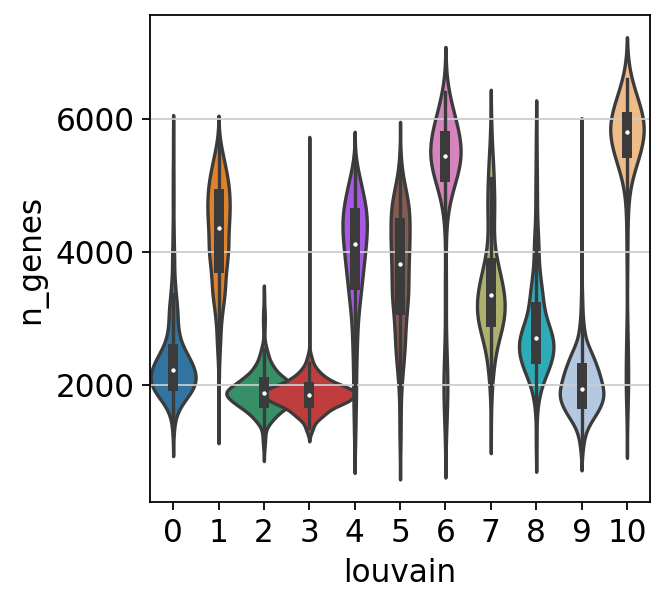

In [37]:
sns.violinplot(x="louvain", y="n_genes", data=adata.obs, width = 2)

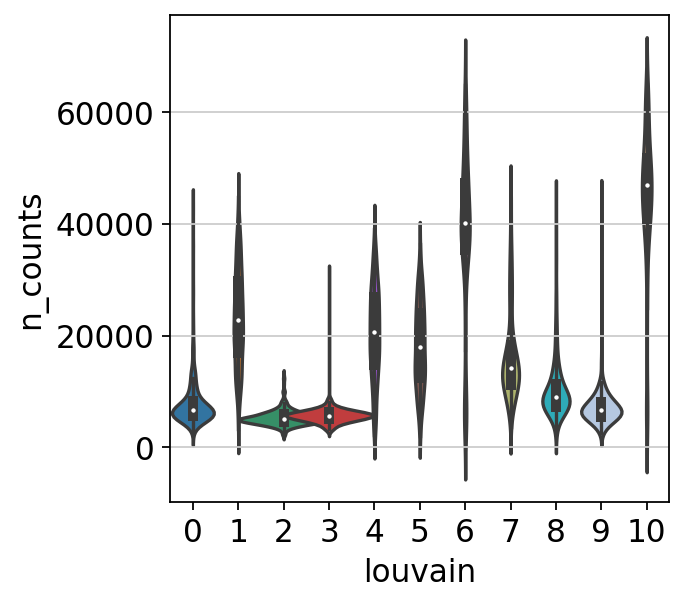

In [38]:
sns.violinplot(x="louvain", y="n_counts", data=adata.obs, width = 2)

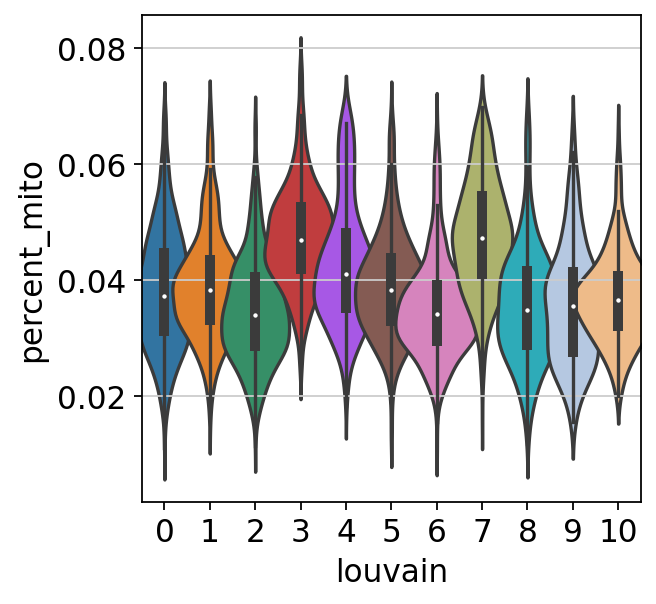

In [39]:
sns.violinplot(x="louvain", y="percent_mito", data=adata.obs, width = 2)

### 2.2 Summary plots -- cell type

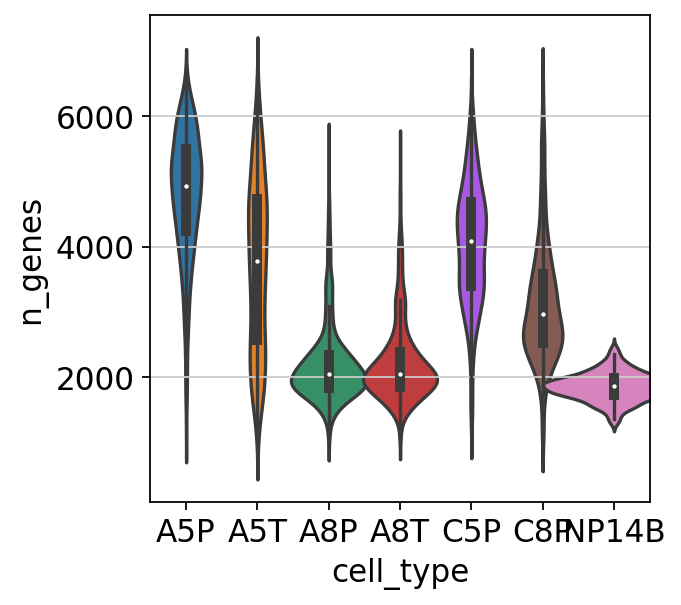

In [40]:
sns.violinplot(x="cell_type", y="n_genes", data=adata.obs, width = 2)

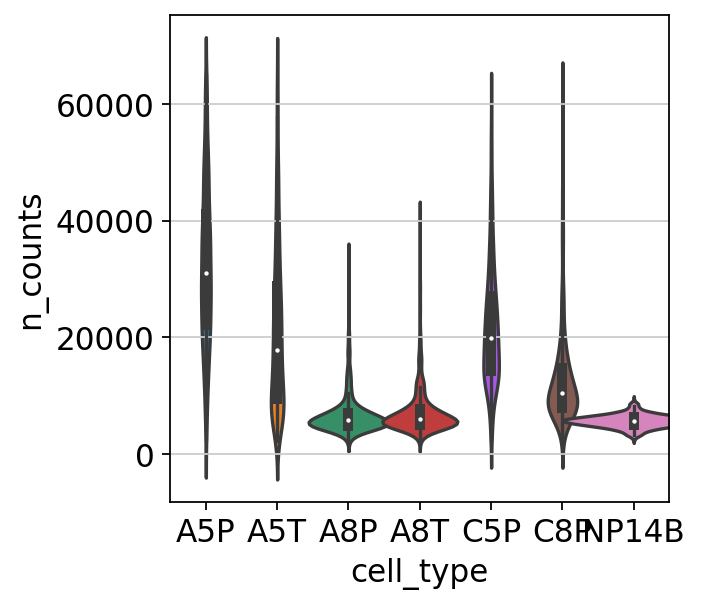

In [41]:
sns.violinplot(x="cell_type", y="n_counts", data=adata.obs, width = 2)

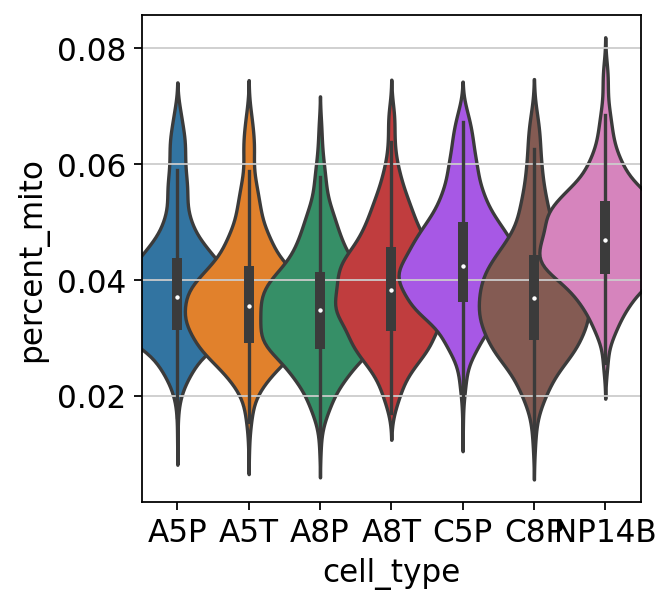

In [42]:
sns.violinplot(x="cell_type", y="percent_mito", data=adata.obs, width = 2)

### 2.1 Average expression

In [6]:
sum_dir = new_wk_dir + "/1_avg_expr"
Path(sum_dir).mkdir(parents=True, exist_ok=True)
os.chdir(sum_dir)

In [7]:
adata.obs['louvain_celltype'] = ["%s_%s"%(str(y), str(x)) for index, (x,y) in enumerate(zip(adata.obs['cell_type'].values, adata.obs['louvain'].values))]
adata.obs['louvain_celltype_general'] = ["%s_%s"%(str(y), str(x)[0]) for index, (x,y) in enumerate(zip(adata.obs['cell_type'].values, adata.obs['louvain'].values))]
adata.obs['cell_type_simp'] = [x[:-1] for x in adata.obs['cell_type']]
adata.obs['cell_type_simp'] = ["NAV" if x == 'NP14' else x for x in adata.obs['cell_type_simp']]

In [16]:
use_cols = ['cell_type_simp'] # 'cell_type', 'louvain', 'louvain_celltype', "louvain_celltype_general"

expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_types = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = "gene_name"
    use_key_mean_df.to_csv("%s_mean_scaled_expr.csv"%use_key)
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x), axis=0) 
    use_key_z_df.to_csv("%s_mean_scaled_expr_z.csv"%use_key)

*Calculate average for Cl13 or Arm together with Naive*

In [52]:
adata.obs['louvain_celltype_general_A'] = [x.replace("N", "A") for x in adata.obs['louvain_celltype_general']]
adata.obs['louvain_celltype_general_A'] = ["other" if "A" not in x else x for x in adata.obs['louvain_celltype_general_A']]

use_cols = ['louvain_celltype_general_A']

expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_types = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = "gene_name"
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x), axis=0)
    del use_key_z_df['other']
    del use_key_mean_df['other']
use_key_mean_df_all = use_key_mean_df
use_key_z_df_all = use_key_z_df

adata.obs['louvain_celltype_general_C'] = [x.replace("N", "C") for x in adata.obs['louvain_celltype_general']]
adata.obs['louvain_celltype_general_C'] = ["other" if "C" not in x else x for x in adata.obs['louvain_celltype_general_C']]

use_cols = ['louvain_celltype_general_C']

expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_types = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = "gene_name"
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x), axis=0)
    del use_key_z_df['other']
    del use_key_mean_df['other']
use_key_mean_df_all = use_key_mean_df_all.join(use_key_mean_df)
use_key_z_df_all = use_key_z_df_all.join(use_key_z_df)

use_key_mean_df_all.to_csv("louvain_celltype_general_withNAV_mean_scaled_expr.csv")
use_key_z_df_all.to_csv("louvain_celltype_general_withNAV_mean_scaled_expr_z.csv")